In [1]:
# import librosa
# import IPython.display
# import matplotlib as mpl
# import matplotlib.font_manager as fm

In [2]:
# data.zip 파일 업로드

In [3]:
########################################################################
# import default python-library
########################################################################
import pickle
import os
import sys
import glob
########################################################################


########################################################################
# import additional python-library
########################################################################
import numpy as np
import librosa
import librosa.core
import librosa.display
import librosa.feature
import yaml
import logging
# from import
from tqdm import tqdm
from sklearn import metrics
from keras.models import Model
from keras.layers import Input, Dense
########################################################################

In [4]:
########################################################################
# setup STD I/O
########################################################################
"""
Standard output is logged in "autoencoder.log".
"""
logging.basicConfig(level=logging.DEBUG, filename="autoencoder.log")
logger = logging.getLogger(' ')
handler = logging.StreamHandler()
formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)
########################################################################

In [5]:
########################################################################

# wav file Input
def file_load(wav_name, mono=False):
    """
    load .wav file.

    wav_name : str
        target .wav file
    sampling_rate : int
        audio file sampling_rate
    mono : boolean
        When load a multi channels file and this param True, the returned data will be merged for mono data

    return : numpy.array( float )
    """
    try:
        return librosa.load(wav_name, sr=None, mono=mono)
    except:
        logger.error("file_broken or not exists!! : {}".format(wav_name))


def demux_wav(wav_name, channel=0):
    """
    demux .wav file.

    wav_name : str
        target .wav file
    channel : int
        target channel number

    return : numpy.array( float )
        demuxed mono data

    Enabled to read multiple sampling rates.

    Enabled even one channel.
    """
    try:
        multi_channel_data, sr = file_load(wav_name)
        if multi_channel_data.ndim <= 1:
            return sr, multi_channel_data

        return sr, np.array(multi_channel_data)[channel, :]

    except ValueError as msg:
        logger.warning(f'{msg}')


########################################################################

In [6]:
import matplotlib.pyplot as plt

# spectrograms 변환 함수 만들기
# 참고: https://librosa.org/doc/main/generated/librosa.feature.melspectrogram.html
def make_iamge(SOURCE,
               TARGET,
               n_mels=128,
               frames=5,
               n_fft=1024,
               hop_length=512,
               power=2.0):

    # 01 calculate the number of dimensions
    dims = n_mels * frames

    # 02 generate melspectrogram using librosa (**kwargs == param["librosa"])
    sr, y = demux_wav(SOURCE)

    # file = SOURCE
    # y, sr = librosa.load(file) # (default  sr=22050)
    # Return
      # y: np.ndarray [shape=(n,) or (…, n)] / audio time series. Multi-channel is supported.
      # sr: number > 0 [scalar / sampling rate of
    # S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    mel_spectrogram = librosa.feature.melspectrogram(y=y,
                                                     sr=sr,
                                                     n_fft=n_fft,
                                                     hop_length=hop_length,
                                                     n_mels=n_mels,
                                                     power=power)

    # Returns
      # S: np.ndarray [shape=(…, n_mels, t)] / Mel spectrogram
    S_dB = librosa.power_to_db(mel_spectrogram, ref=np.max)
    if TARGET == '':
      plt.figure(figsize=(12, 4))
      librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
      plt.title('mel power spectrogram')
      plt.colorbar(format='%+02.0f dB')
      plt.tight_layout()
      plt.show()
    else:
      fig = plt.figure(figsize=(15, 15))
      plt.axis('off')
      librosa.display.specshow(S_dB, sr=sr)
      plt.savefig(TARGET, bbox_inches='tight', pad_inches=0)
      plt.close(fig)  

In [7]:
import matplotlib.pyplot as plt

# spectrograms 변환 함수 만들기
# 참고: https://librosa.org/doc/main/generated/librosa.feature.melspectrogram.html
def make_iamge2(SOURCE, TARGET, FIG_SIZE):

    # 01 calculate the number of dimensions
    #dims = n_mels * frames

    # 02 generate melspectrogram using librosa (**kwargs == param["librosa"])
    sr, y = demux_wav(SOURCE)

    # STFT -> spectrogram
    hop_length = 512  # in num. of samples
    n_fft = 2048  # window in num. of samples

    # perform stft
    stft = librosa.stft(y, n_fft=n_fft, hop_length=hop_length)

    # calculate abs values on complex numbers to get magnitude
    spectrogram = np.abs(stft)  # np.abs(stft) ** 2

    # apply logarithm to cast amplitude to Decibels
    log_spectrogram = librosa.amplitude_to_db(spectrogram)

    if TARGET == '':
      plt.figure(figsize=(12, 4))
      librosa.display.specshow(log_spectrogram, sr=sr, x_axis='time', y_axis='mel')
      plt.title('mel power spectrogram')
      plt.colorbar(format='%+02.0f dB')
      plt.tight_layout()
      plt.show()
    else:
      fig = plt.figure(figsize=FIG_SIZE)
      plt.axis('off')
      librosa.display.specshow(log_spectrogram, sr=sr, hop_length=hop_length)
      plt.savefig(TARGET, bbox_inches='tight', pad_inches=0)
      plt.close(fig)  

In [8]:
# https://wfdb.readthedocs.io/en/latest/
# The native Python waveform-database (WFDB) package
# A library of tools for reading, writing, and processing WFDB signals and annotations.
import wfdb

In [9]:
# import PIL
# import PIL.Image
# import tensorflow as tf
# import tensorflow_datasets as tfds

# 이미지 로드 및 전처리
# 참고: https://www.tensorflow.org/tutorials/load_data/images?hl=ko
#       Tensorflow공식 튜토리얼: 이미지 로드 및 전처리하기 
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
# import tensorflow_datasets as tfds

In [10]:
print(tf.__version__)

2.8.0


In [11]:
# 데이터세트 형식으로 만들기
import pathlib

# data_dir = pathlib.Path('./content/data/out')
data_dir = pathlib.Path('./dataset/57cc_out')
print(type(data_dir))
print(data_dir)

<class 'pathlib.WindowsPath'>
dataset\57cc_out


In [12]:
# image count
# image_count = len(list(data_dir.glob('*/*.jpg')))
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

45


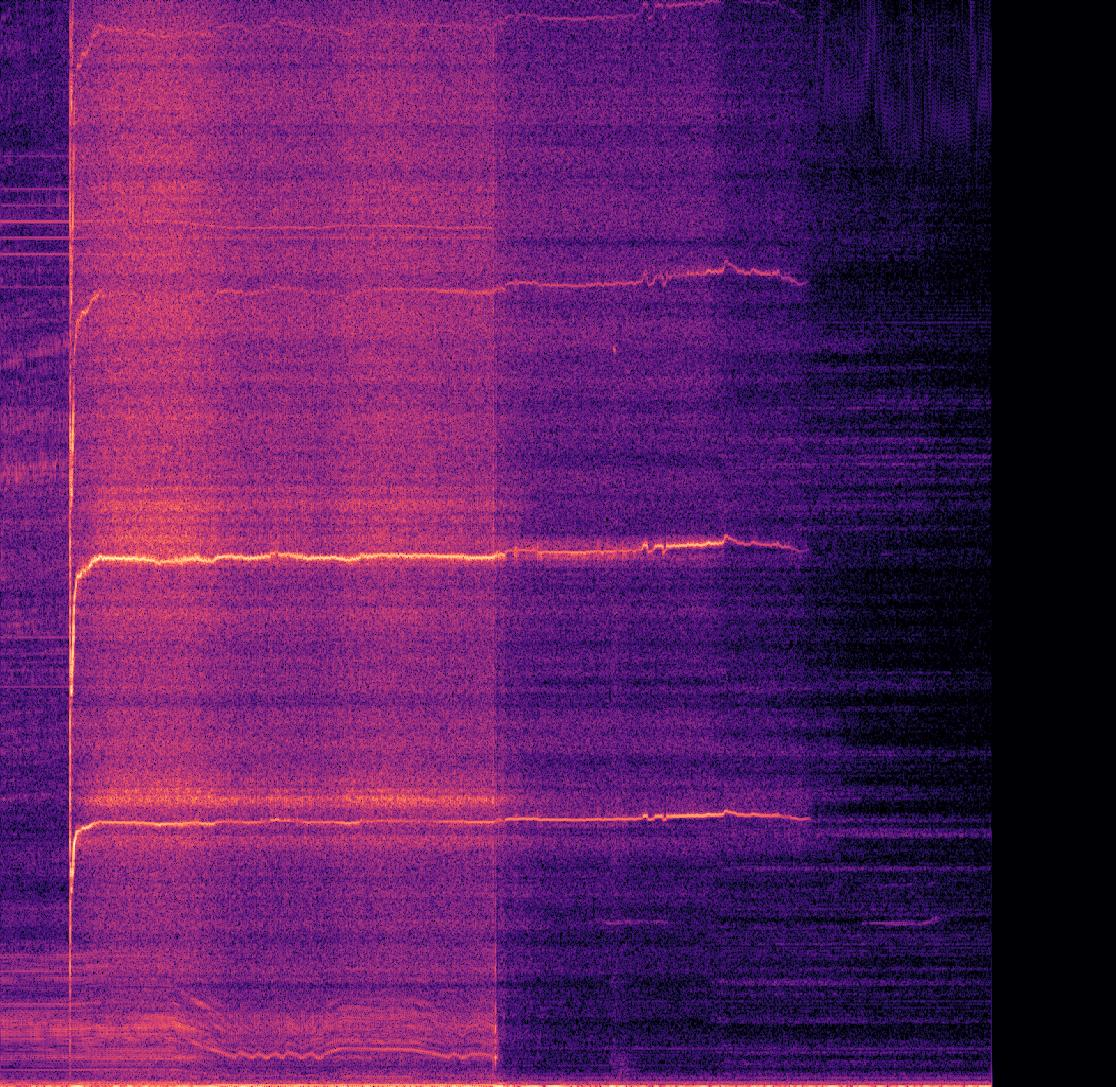

In [13]:
# image 1개 보기
# a_h = list(data_dir.glob('a_h/*'))
normal = list(data_dir.glob('normal/*'))
PIL.Image.open(str(normal[11]))

In [14]:
from tensorflow.python.keras.layers.core import Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import layers, losses
from sklearn.metrics import accuracy_score, precision_score, recall_score
import tensorflow.keras as keras
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import pathlib
import librosa
import librosa.display
import concurrent.futures

In [15]:
'''
2. Load training images  
'''
# resize and normalize data for training


def create_training_data(data_path, size=224):
    training_data = []
    # for category in CATEGORIES:  # "baseline" and "rattle"

    #     path = os.path.join(data_path, category)  # create path
    #     # get the classification  (0 or a 1). 0=baseline 1=rattle
    #     class_index = CATEGORIES.index(category)

    # iterate over each image
    for image in os.listdir(data_path):
        # check file extention
        if image.endswith(".jpg"):
            try:
                data_path = pathlib.Path(data_path)
                full_name = str(pathlib.Path.joinpath(data_path, image))
                data = cv2.imread(str(full_name), 0)
                # resize to make sure data consistency
                resized_data = cv2.resize(data, (size, size))
                # add this to our training_data
                training_data.append([resized_data])
            except Exception as err:
                print("an error has occured: ", err, str(full_name))

    # normalize data
    training_data = np.array(training_data)/255.
    # reshape
    training_data = np.array(training_data).reshape(-1, size, size)
    return training_data

In [16]:
'''
3. Build autoencoder 
'''
# Define a convolutional Autoencoder


class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        # input layer
        self.latent_dim = latent_dim
        # 1st dense layer
        # self.encoder = tf.keras.Sequential([
        #     layers.Flatten(),
        #     layers.Dense(128, activation='relu'),
        #     layers.Dense(64, activation='relu'),
        #     layers.Dense(32, activation='relu'),

        # ])
        # self.decoder = tf.keras.Sequential([
        #     layers.Dense(64, activation='relu'),
        #     layers.Dense(128, activation='relu'),
        #     layers.Dense(224*224, activation='sigmoid'),
        #     layers.Reshape((224, 224))
        # ])
        # self.encoder = tf.keras.Sequential([
        #     layers.Flatten(),
        #     layers.Dense(256, activation='relu'),
        #     layers.Dense(128, activation='relu'),
        #     layers.Dense(64, activation='relu'),

        # ])
        # self.decoder = tf.keras.Sequential([
        #     layers.Dense(128, activation='relu'),
        #     layers.Dense(256, activation='relu'),
        #     layers.Dense(224*224, activation='sigmoid'),
        #     layers.Reshape((224, 224))
        # ])
        self.encoder = tf.keras.Sequential([
            layers.Flatten(),
            layers.Dense(256, activation='relu'),
            layers.Dense(256, activation='relu'),
            layers.Dense(128, activation='relu'),

        ])
        self.decoder = tf.keras.Sequential([
            layers.Dense(256, activation='relu'),
            layers.Dense(256, activation='relu'),
            layers.Dense(224*224, activation='sigmoid'),
            layers.Reshape((224, 224))
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [138]:
'''
4. Set threshold
'''


def model_threshold(autoencoder, x_train):
    encoded_imgs = autoencoder.encoder(x_train).numpy()
    decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()
    loss = tf.keras.losses.mse(decoded_imgs, x_train)
    mean = np.mean(loss)
    std = np.std(loss)
    threshold = np.mean(loss) + 0.5*np.std(loss)
    return loss, mean, std, threshold

In [18]:
'''
5. Make an inference
'''


def spectrogram_loss(autoencoder, spectrogram, size=224):
    data = np.ndarray(shape=(1, size, size), dtype=np.float32)
    # individual sample
    # Load an image from a file
    data = cv2.imread(str(spectrogram), 0)
    # resize to make sure data consistency
    resized_data = cv2.resize(data, (size, size))
    # nomalize img
    normalized_data = resized_data.astype('float32') / 255.
    # test an image
    encoded = autoencoder.encoder(normalized_data.reshape(-1, size, size))
    decoded = autoencoder.decoder(encoded)
    loss = tf.keras.losses.mse(decoded, normalized_data)
    sample_loss = np.mean(loss) + np.std(loss)
    return sample_loss

In [19]:
'''
2. Load training images
'''
data_path = "./dataset/57cc_out/normal"
x_train = create_training_data(data_path)

data_path = "./dataset/57cc_out/normal_test"
x_test_normal = create_training_data(data_path)

data_path = "./dataset/57cc_out/abnormal"
x_test_abnormal = create_training_data(data_path)

In [20]:
from sklearn.model_selection import train_test_split
X_train_split, X_test_split, __ , __ = train_test_split(x_train, x_train, test_size=0.04, random_state=20)


In [21]:
print(X_train_split.shape)
print(X_test_split.shape)

(39, 224, 224)
(2, 224, 224)


In [22]:
'''
3. Build autoencoder 
'''
autoencoder = Autoencoder(latent_dim=64 * 1)
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

history = autoencoder.fit(X_train_split, X_train_split,
						  epochs=100,
						  #shuffle=True,
						  batch_size=16, verbose=1,
						  validation_data=(X_test_split, X_test_split))

# history = autoencoder.fit(x_train, x_train,
# 						  epochs=100,
# 						  #shuffle=True,
# 						  batch_size=16, verbose=1)

Epoch 1/100
3/3 [==============================] - 1s 64ms/step - loss: 0.1029 - val_loss: 0.0782
Epoch 2/100
3/3 [==============================] - 0s 17ms/step - loss: 0.0479 - val_loss: 0.0177
Epoch 3/100
3/3 [==============================] - 0s 17ms/step - loss: 0.0190 - val_loss: 0.0121
Epoch 4/100
3/3 [==============================] - 0s 17ms/step - loss: 0.0111 - val_loss: 0.0081
Epoch 5/100
3/3 [==============================] - 0s 18ms/step - loss: 0.0067 - val_loss: 0.0054
Epoch 6/100
3/3 [==============================] - 0s 17ms/step - loss: 0.0059 - val_loss: 0.0060
Epoch 7/100
3/3 [==============================] - 0s 17ms/step - loss: 0.0058 - val_loss: 0.0050
Epoch 8/100
3/3 [==============================] - 0s 17ms/step - loss: 0.0054 - val_loss: 0.0042
Epoch 9/100
3/3 [==============================] - 0s 18ms/step - loss: 0.0050 - val_loss: 0.0045
Epoch 10/100
3/3 [==============================] - 0s 17ms/step - loss: 0.0049 - val_loss: 0.0035
Epoch 11/100
3/3 [=

In [23]:
# a summary of architecture
autoencoder.encoder.summary()
autoencoder.decoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 50176)             0         
                                                                 
 dense (Dense)               (None, 256)               12845312  
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
Total params: 12,944,000
Trainable params: 12,944,000
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)      

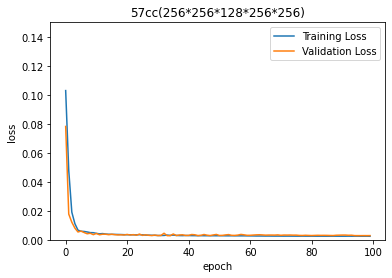

In [24]:
# plot history
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
# plt.title("57cc(128*64*32*64*128)")
# plt.title("57cc(256*128*64*128*256)")
plt.title("57cc(256*256*128*256*256)")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.ylim([0, 0.15])
plt.show()

In [139]:
print("loss: ", np.mean(history.history["loss"]))
print("val_loss: ", np.mean(history.history["val_loss"]))

loss:  0.00474142768420279
val_loss:  0.00438388645183295


In [140]:
# # save and load a mode
# autoencoder.save('./model_57cc/')
# autoencoder = keras.models.load_model('./model_57cc/')

In [141]:
# # load autoencoder model
# if autoencoder is None:
# 	autoencoder = Autoencoder(latent_dim=64 * 2)
# 	autoencoder = keras.models.load_model('./model_57cc/')

In [142]:
'''
4. Set threshold
'''
loss, mean, std, threshold = model_threshold(autoencoder, x_train)
# loss = tf.keras.losses.mse(decoded_imgs, x_train)
# threshold = np.mean(loss) + np.std(loss)
print("Loss mean: ", mean)
print("Loss standard deviation: ", std)
print("Threshold: ", threshold)

Loss mean:  0.0024399078869327176
Loss standard deviation:  0.0031905451673428322
Threshold:  0.004035180470604134


In [143]:
# # load autoencoder model
# if autoencoder is None:
# 	autoencoder = keras.models.load_model('./model_57cc/')

In [144]:
# '''
# 5. Make an inference - abnormal 1
# '''
# # get statistics for each spectrogram
# # file = 'c:/data/sample/test_OK_anomal_121282111NB982000301518.jpg'
# # file = 'c:/data/sample/test_OK_121282111NB982000295218.jpg'
# file = './dataset/57cc_out/abnormal/57cc_NO_121281111NB9820002663.jpg'
# sample = plt.imread(file)
# plt.imshow(sample)
# sample = pathlib.Path(file)
# sample_loss = spectrogram_loss(autoencoder, sample)

In [145]:
# if sample_loss > threshold:
# 	print(
# 		f'Loss is bigger than threshold \n \
# 		  Sample Loss: {sample_loss} \n \
# 		  Threshold: {threshold} ')
# else:
# 	print(
# 		f'Loss is smaller than threshold \n \
# 		  Sample Loss: {sample_loss} \n \
# 		  Threshold: {threshold} ')

In [146]:
# '''
# 5. Make an inference - abnormal 2
# '''
# # get statistics for each spectrogram
# # file = 'c:/data/sample/test_OK_anomal_121282111NB982000301518.jpg'
# # file = 'c:/data/sample/test_OK_121282111NB982000295218.jpg'
# file = './dataset/57cc_out/abnormal/57cc_NO_121282111NB9820003015.jpg'
# sample = plt.imread(file)
# plt.imshow(sample)
# sample = pathlib.Path(file)
# sample_loss = spectrogram_loss(autoencoder, sample)

In [147]:
# if sample_loss > threshold:
# 	print(
# 		f'Loss is bigger than threshold \n \
# 		  Sample Loss: {sample_loss} \n \
# 		  Threshold: {threshold} ')
# else:
# 	print(
# 		f'Loss is smaller than threshold \n \
# 		  Sample Loss: {sample_loss} \n \
# 		  Threshold: {threshold} ')

In [148]:
# '''
# 5. Make an inference - normal 1
# '''
# # get statistics for each spectrogram
# # file = 'c:/data/sample/test_OK_anomal_121282111NB982000301518.jpg'
# # file = 'c:/data/sample/test_OK_121282111NB982000295218.jpg'
# file = './dataset/57cc_out/normal_test/test_57cc_OK_121282111NB9820002981.jpg'
# sample = plt.imread(file)
# plt.imshow(sample)
# sample = pathlib.Path(file)
# sample_loss = spectrogram_loss(autoencoder, sample)

In [149]:
# if sample_loss > threshold:
# 	print(
# 		f'Loss is bigger than threshold \n \
# 		  Sample Loss: {sample_loss} \n \
# 		  Threshold: {threshold} ')
# else:
# 	print(
# 		f'Loss is smaller than threshold \n \
# 		  Sample Loss: {sample_loss} \n \
# 		  Threshold: {threshold} ')

In [150]:
# '''
# 5. Make an inference - normal 2
# '''
# # get statistics for each spectrogram
# # file = 'c:/data/sample/test_OK_anomal_121282111NB982000301518.jpg'
# # file = 'c:/data/sample/test_OK_121282111NB982000295218.jpg'
# file = './dataset/57cc_out/normal_test/test_57cc_OK_121282111NB9820002990.jpg'
# sample = plt.imread(file)
# plt.imshow(sample)
# sample = pathlib.Path(file)
# sample_loss = spectrogram_loss(autoencoder, sample)

In [151]:
# if sample_loss > threshold:
# 	print(
# 		f'Loss is bigger than threshold \n \
# 		  Sample Loss: {sample_loss} \n \
# 		  Threshold: {threshold} ')
# else:
# 	print(
# 		f'Loss is smaller than threshold \n \
# 		  Sample Loss: {sample_loss} \n \
# 		  Threshold: {threshold} ')

In [152]:
# 훈련 세트에서 정상 ECG에 대한 재구성 오류를 플롯합니다.
x_train_loss, x_train_mean, x_train_std, x_train_threshold = model_threshold(autoencoder, x_train)
x_tran_loss_all = []
for i in range(x_train_loss.shape[0]):
    x_tran_loss_all.append(np.mean(x_train_loss[i]))
    print(i, ": ", np.mean(x_train_loss[i]))

0 :  0.003195288609150067
1 :  0.0019190693110928865
2 :  0.002603593254711264
3 :  0.002616869948307065
4 :  0.003036425068331336
5 :  0.002239970651540608
6 :  0.0031208479025630212
7 :  0.002300665839710839
8 :  0.0014744688841339941
9 :  0.0025293198373455054
10 :  0.0024533165754057978
11 :  0.0026521823286559903
12 :  0.0021006959679707752
13 :  0.0024429522695676334
14 :  0.0023956928246187366
15 :  0.0026611003819515394
16 :  0.0021820025324020133
17 :  0.0026258269064470255
18 :  0.0034884570942254893
19 :  0.002340285757488721
20 :  0.0024220804510015964
21 :  0.002270862749923511
22 :  0.0021736393386716083
23 :  0.0023389147706235325
24 :  0.0019263660759362717
25 :  0.0021518257368163276
26 :  0.0024359506948703094
27 :  0.0017768911506078626
28 :  0.002760781370650021
29 :  0.0022864523474599055
30 :  0.0024491564999212464
31 :  0.0026914882388174573
32 :  0.002166108857715535
33 :  0.0023522620577633544
34 :  0.002398758606891743
35 :  0.0024658144015061154
36 :  0.00275

      loss:  0.004035180470604134
mean(loss):  0.0024399078869327176
 std(loss):  0.0031905451673428322
 threshold:  0.004035180470604134
strong threshold:  0.004035180470604134


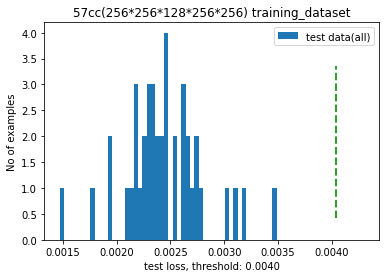

In [153]:
print("      loss: ", threshold)
print("mean(loss): ", mean)
print(" std(loss): ", std)
print(" threshold: ", threshold)
print("strong threshold: ", mean+std/2)

x_min = min(x_tran_loss_all+[threshold])-0.1*min(x_tran_loss_all+[threshold])
x_max = 1.1*max(x_tran_loss_all+[threshold])

# plt.title("57cc(128*64*32*64*128) training_dataset")
# plt.title("57cc(256*128*64*128*256) training_dataset")
plt.title("57cc(256*256*128*256*256) training_dataset")

plt.hist(x_tran_loss_all, bins=50, color='C0', label='test data(all)')
plt.xlabel(f"test loss, threshold: {threshold:.4f}")
plt.xlim(x_min, x_max)      # X축의 범위: [xmin, xmax]
plt.axvline(threshold, 0.1, 0.8, color='C2', linestyle='--', linewidth=2)
plt.legend(loc='upper right')

plt.ylabel("No of examples")
plt.show()



In [154]:
ok_loss, ok_mean, ok_std, ok_threshold = model_threshold(autoencoder, x_test_normal)
ok_loss_all = []
for i in range(ok_loss.shape[0]):
    ok_loss_all.append(np.mean(ok_loss[i]))
    print(i, ": ", np.mean(ok_loss[i]))

0 :  0.0027892259879900546
1 :  0.002662076089281744


threshold:  0.004035180470604134


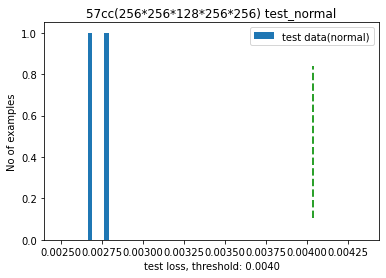

In [155]:
print("threshold: ", threshold)

x_min = min(ok_loss_all+[threshold])-0.1*min(ok_loss_all+[threshold])
x_max = 1.1*max(ok_loss_all+[threshold])

# plt.title("57cc(128*64*32*64*128) test_normal")
# plt.title("57cc(256*128*64*128*256) test_normal")
plt.title("57cc(256*256*128*256*256) test_normal")

plt.hist(ok_loss_all, bins=5, color='C0', label='test data(normal)')
plt.xlabel(f"test loss, threshold: {threshold:.4f}")
plt.xlim(x_min, x_max)      # X축의 범위: [xmin, xmax]
plt.axvline(threshold, 0.1, 0.8, color='C2', linestyle='--', linewidth=2)
plt.legend(loc='upper right')

plt.ylabel("No of examples")
plt.show()

In [156]:
nok_loss, nok_mean, nok_std, nok_threshold = model_threshold(autoencoder, x_test_abnormal)
nok_loss_all = []
for i in range(nok_loss.shape[0]):
    nok_loss_all.append(np.mean(nok_loss[i]))
    print(i, ": ", np.mean(nok_loss[i]))

0 :  0.003550753608618489
1 :  0.005531090362392873


In [157]:
print(nok_loss_all+[threshold])

[0.003550753608618489, 0.005531090362392873, 0.004035180470604134]


threshold:  0.004035180470604134


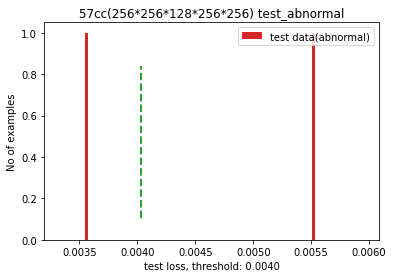

In [158]:
print("threshold: ", threshold)

x_min = min(nok_loss_all+[threshold])-0.1*min(nok_loss_all+[threshold])
x_max = 1.1*max(nok_loss_all+[threshold])

# plt.title("57cc(128*64*32*64*128) test_abnormal")
# plt.title("57cc(256*128*64*128*256) test_abnormal")
plt.title("57cc(256*256*128*256*256) test_abnormal")

plt.hist(nok_loss_all, bins=100, color='C3', label='test data(abnormal)')
plt.xlabel(f"test loss, threshold: {threshold:.4f}")
plt.xlim(x_min, x_max)      # X축의 범위: [xmin, xmax]
plt.axvline(threshold, 0.1, 0.8, color='C2', linestyle='--', linewidth=2)
plt.legend(loc='upper right')

plt.ylabel("No of examples")
plt.show()

threshold:  0.004035180470604134


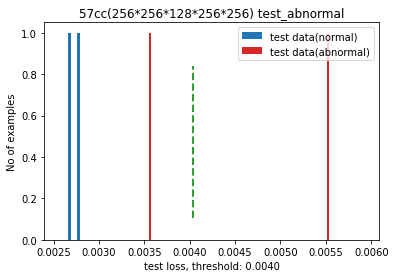

In [159]:
print("threshold: ", threshold)

x_min = min(ok_loss_all+nok_loss_all+[threshold])-0.1*min(ok_loss_all+nok_loss_all+[threshold])
x_max = 1.1*max(ok_loss_all+nok_loss_all+[threshold])

# plt.title("57cc(128*64*32*64*128) test_all")
# plt.title("57cc(256*128*64*128*256) test_abnormal")
plt.title("57cc(256*256*128*256*256) test_abnormal")

# plt.hist(ok_loss_all+nok_loss_all, bins=500, label='test data(abnormal)')

plt.hist(ok_loss_all, bins=5, color='C0', label='test data(normal)')
plt.hist(nok_loss_all, bins=100, color='C3', label='test data(abnormal)')

plt.xlabel(f"test loss, threshold: {threshold:.4f}")
plt.xlim(x_min, x_max)      # X축의 범위: [xmin, xmax]
plt.axvline(threshold, 0.1, 0.8, color='C2', linestyle='--', linewidth=2)
plt.legend(loc='upper right')

plt.ylabel("No of examples")
plt.show()

In [160]:
print(ok_loss_all)
print(nok_loss_all)

[0.0027892259879900546, 0.002662076089281744]
[0.003550753608618489, 0.005531090362392873]


In [161]:
# x_train: 36, x_test_normal: 2, x_test_abnormal: 2

# Label: 정상: 1, 비정상: 0
x_train_label = ['1','1','1','1','1','1','1','1','1','1'\
                ,'1','1','1','1','1','1','1','1','1','1'\
                ,'1','1','1','1','1','1','1','1','1','1'\
                ,'1','1','1','1','1','1','1','1','1','1'
                ,'1']
x_test_normal_label = ['1','1']
x_test_abnormal_label = ['0','0']
x_train_label = np.array(x_train_label).astype(bool)
x_test_normal_label = np.array(x_test_normal_label).astype(bool)
x_test_abnormal_label = np.array(x_test_abnormal_label).astype(bool)

In [162]:
print(type(x_train), x_train.shape)
print(type(x_test_normal), x_test_normal.shape)
print(type(x_test_abnormal), x_test_abnormal.shape)
print(type(x_train_label), x_train_label.shape)
print(type(x_test_normal_label), x_test_normal_label.shape)
print(type(x_test_abnormal_label), x_test_abnormal_label.shape)

<class 'numpy.ndarray'> (41, 224, 224)
<class 'numpy.ndarray'> (2, 224, 224)
<class 'numpy.ndarray'> (2, 224, 224)
<class 'numpy.ndarray'> (41,)
<class 'numpy.ndarray'> (2,)
<class 'numpy.ndarray'> (2,)


In [163]:
all_data = np.concatenate([x_train, x_test_normal], axis=0)
all_data = np.concatenate([all_data, x_test_abnormal], axis=0)
print(all_data.shape)

(45, 224, 224)


In [164]:
# all_data_label = x_train_label + x_test_normal_label+ x_test_abnormal_label
# print(len(all_data_label))
# print(all_data_label)
all_data_label = np.concatenate([x_train_label, x_test_normal_label], axis=0)
all_data_label = np.concatenate([all_data_label, x_test_abnormal_label], axis=0)
print(all_data_label.shape)
print(print(all_data_label))

(45,)
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True False False]
None


0 :  0.003195288609150067
1 :  0.0019190693110928865
2 :  0.002603593254711264
3 :  0.002616869948307065
4 :  0.003036425068331336
5 :  0.002239970651540608
6 :  0.0031208479025630212
7 :  0.002300665839710839
8 :  0.0014744688841339941
9 :  0.0025293198373455054
10 :  0.0024533165754057978
11 :  0.0026521823286559903
12 :  0.0021006959679707752
13 :  0.0024429522695676334
14 :  0.0023956928246187366
15 :  0.0026611003819515394
16 :  0.0021820025324020133
17 :  0.0026258269064470255
18 :  0.0034884570942254893
19 :  0.002340285757488721
20 :  0.0024220804510015964
21 :  0.002270862749923511
22 :  0.0021736393386716083
23 :  0.0023389147706235325
24 :  0.0019263660759362717
25 :  0.0021518257368163276
26 :  0.0024359506948703094
27 :  0.0017768911506078626
28 :  0.002760781370650021
29 :  0.0022864523474599055
30 :  0.0024491564999212464
31 :  0.0026914882388174573
32 :  0.0021661380511272302
33 :  0.002352153028630887
34 :  0.0023988591615191697
35 :  0.002465766291205748
36 :  0.00275

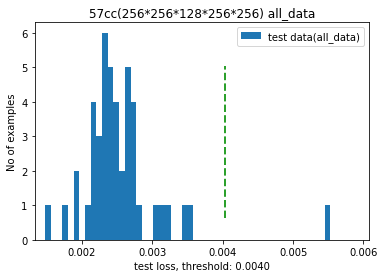

In [165]:
# 전체 세트에서 정상 ECG에 대한 재구성 오류를 플롯합니다.

reconstructions = autoencoder.predict(all_data)
all_data_loss = tf.keras.losses.mse(reconstructions, all_data)
all_data_loss_all = []
for i in range(all_data_loss.shape[0]):
    all_data_loss_all.append(np.mean(all_data_loss[i]))
    print(i, ": ", np.mean(all_data_loss[i]))

print("threshold: ", threshold)

x_min = min(all_data_loss_all+[threshold])-0.1*min(all_data_loss_all+[threshold])
x_max = 1.1*max(all_data_loss_all+[threshold])

# plt.title("57cc(128*64*32*64*128) all_data")
# plt.title("57cc(256*128*64*128*256) all_data")
plt.title("57cc(256*256*128*256*256) all_data")

plt.hist(all_data_loss_all, bins=50, color='C0', label='test data(all_data)')
plt.xlabel(f"test loss, threshold: {threshold:.4f}")
plt.xlim(x_min, x_max)      # X축의 범위: [xmin, xmax]
plt.axvline(threshold, 0.1, 0.8, color='C2', linestyle='--', linewidth=2)
plt.legend(loc='upper right')

plt.ylabel("No of examples")
plt.show()


In [166]:
print("all_data mean of loss: ", np.mean(all_data_loss))
print("all_data standard deviation of loss: ", np.std(all_data_loss))
print("all_data Threshold: ", np.mean(all_data_loss) + np.std(all_data_loss))

all_data mean of loss:  0.002545988205264117
all_data standard deviation of loss:  0.0031801296362855974
all_data Threshold:  0.005726117841549715


In [167]:
# 재구성 오류가 임계값보다 큰 경우 ECG를 이상으로 분류합니다.
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mse(reconstructions, data)
  loss_all = []
  for i in range(data.shape[0]):
      loss_all.append(np.mean(loss[i]))
  return tf.math.less(loss_all, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

In [168]:
preds = predict(autoencoder, all_data, threshold)
print(preds)
print(all_data_label)
print_stats(preds, all_data_label)

tf.Tensor(
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True False], shape=(45,), dtype=bool)
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True False False]
Accuracy = 0.9777777777777777
Precision = 0.9772727272727273
Recall = 1.0


In [169]:
preds = predict(autoencoder, x_train, threshold)
print(preds)
print(x_train_label)
print_stats(preds, x_train_label)

tf.Tensor(
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True], shape=(41,), dtype=bool)
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True]
Accuracy = 1.0
Precision = 1.0
Recall = 1.0


In [170]:
preds = predict(autoencoder, x_test_normal, threshold)
print(preds)
print(x_test_normal_label)
print_stats(preds, x_test_normal_label)

tf.Tensor([ True  True], shape=(2,), dtype=bool)
[ True  True]
Accuracy = 1.0
Precision = 1.0
Recall = 1.0


In [171]:
preds = predict(autoencoder, x_test_abnormal, threshold)
print(preds)
print(x_test_abnormal_label)
print_stats(preds, x_test_abnormal_label)

tf.Tensor([ True False], shape=(2,), dtype=bool)
[False False]
Accuracy = 0.5
Precision = 0.0
Recall = 0.0


c:\Users\astro\anaconda3\envs\ae2\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [172]:
test_all_data = np.concatenate([x_test_normal, x_test_abnormal], axis=0)
test_all_data_label = np.concatenate([x_test_normal_label, x_test_abnormal_label], axis=0)

In [173]:
test_all_loss, test_mean, test_std, test_threshold = model_threshold(autoencoder, test_all_data)
test_all_loss_all = []
for i in range(test_all_loss.shape[0]):
    test_all_loss_all.append(np.mean(test_all_loss[i]))
    print(i, ": ", np.mean(test_all_loss[i]))

0 :  0.0027892259879900546
1 :  0.002662076089281744
2 :  0.003550753608618489
3 :  0.005531090362392873


threshold:  0.004035180470604134


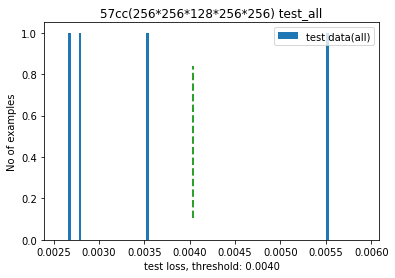

In [174]:
print("threshold: ", threshold)

x_min = min(test_all_loss_all+[threshold])-0.1*min(test_all_loss_all+[threshold])
x_max = 1.1*max(test_all_loss_all+[threshold])

# plt.title("57cc(128*64*32*64*128) test_all")
# plt.title("57cc(256*128*64*128*256) test_all")
plt.title("57cc(256*256*128*256*256) test_all")

plt.hist(test_all_loss_all, bins=100, color='C0', label='test data(all)')
plt.xlabel(f"test loss, threshold: {threshold:.4f}")
plt.xlim(x_min, x_max)      # X축의 범위: [xmin, xmax]
plt.axvline(threshold, 0.1, 0.8, color='C2', linestyle='--', linewidth=2)
plt.legend(loc='upper right')

plt.ylabel("No of examples")
plt.show()

In [175]:
preds = predict(autoencoder, test_all_data, threshold)
print(preds)
print(test_all_data_label)
print_stats(preds, test_all_data_label)

tf.Tensor([ True  True  True False], shape=(4,), dtype=bool)
[ True  True False False]
Accuracy = 0.75
Precision = 0.6666666666666666
Recall = 1.0
